# Modello di Kuramoto:
# $\frac{d \theta _{i} }{dt} = \omega _i + \sum_{j=1}^N K_{ij} \sin (\theta _j - \theta _i ), \ \ i = 1, ..., N$ 

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import random
import numpy as np
import copy
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


In [12]:
# function used

def motion(_q_0, _omegas, _t_max, _dt, network):
    debug = False
    K = 1
    # how many vertices (oscillators)?
    _N = len(network.vs.indices)
    q = _q_0
    t = 0
    q_plot = np.zeros((int(_t_max/_dt), _N))
    dq_plot = np.zeros((int(_t_max/_dt), _N))
    dq0 = _omegas
    for t_count in range(int(_t_max/dt)):
        if debug:   print("\n", t)        
        dq = kuramoto(q, _omegas, K, network, t)
        q_plot[t_count] = q
        dq_plot[t_count] = dq
        if debug: print(dq)
#        q = eulero_esplicito(q, dq, dt)
        q = runge_kutta4(q, dq, dt, t, omegas, K, network )
        q = q  % (2*np.pi)
        t += _dt
    return q_plot, dq_plot

def eulero_esplicito(q, dq, dt):
    return q + dq*dt

def runge_kutta4(q, dq, h, t, omegas, K, network):
    f = kuramoto
    k1_dot_q = f(q, omegas, K, network, t )
    k2_dot_q = f(q + k1_dot_q*h/2, omegas,  K, network, t + h/2)
    k3_dot_q = f(q + k2_dot_q*h/2, omegas, K, network, t + h/2)
    k4_dot_q = f(q + k3_dot_q*h, omegas,  K, network, t + h)
    q = (q + (k1_dot_q + 2*k2_dot_q + 2*k3_dot_q + k4_dot_q)*h/6.0)
    return q

def kuramoto(_q, _omegas, K, network, t):
    _N = len(network.vs.indices)
    _dq = copy.deepcopy(_omegas)
#    print("prima", _dq)
    for i in range(_N):
        for j in range(_N):
            _dq[i] -= network.get_adjacency()[i][j] * K * np.sin(_q[j] - _q[i])
#    print("dopo:",_dq)
    return _dq

In [13]:
#  initial values
# Set a random seed for reproducibility
random.seed(0)
N = 20
dt = 0.1
t_max = 100

q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)

# for plotting
t_span = np.linspace(0, t_max, int(t_max/dt))
name_graph = {1: "Erdős-Rényi", 2: "Watts–Strogatz", 3: "Barabasi-Albert"}

Erdos-Renyi: IGRAPH U--- 20 38 --
+ edges:
 0 --  5  8 10 14 16 17 19    8 --  0  6  7 14 16         16 --  0  4  6  7  8
14 18
 1 --  3  7                   9 -- 10                     17 --  0  6 12 13 15
 2 --  5  6  7               10 --  0  6  7  9            18 --  3  6 15 16
 3 --  1  4 11 15 18 19      11 --  3                     19 --  0  3 12
 4 --  3 15 16               12 -- 17 19
 5 --  0  2                  13 --  6 17
 6 --  2  8 10 13 16 17 18   14 --  0  8 16
 7 --  1  2  8 10 16         15 --  3  4 17 18 
 Watts-Strogatz: IGRAPH U--- 20 37 --
+ edges:
 0 --  1  2  3  4  5  6  7 10 11      10 --  0  6 11
 1 --  0  2  3  6  8 13 15            11 --  0 10
 2 --  0  1  4  5 13 17 19            12 --  6  9
 3 --  0  1 14                        13 --  1  2 18
 4 --  0  2 16 18                     14 --  3  6
 5 --  0  2  8                        15 --  1  6
 6 --  0  1  7  9 10 12 14 15 16 17   16 --  4  6
 7 --  0  6                           17 --  2  6
 8 --  1  5  9 19

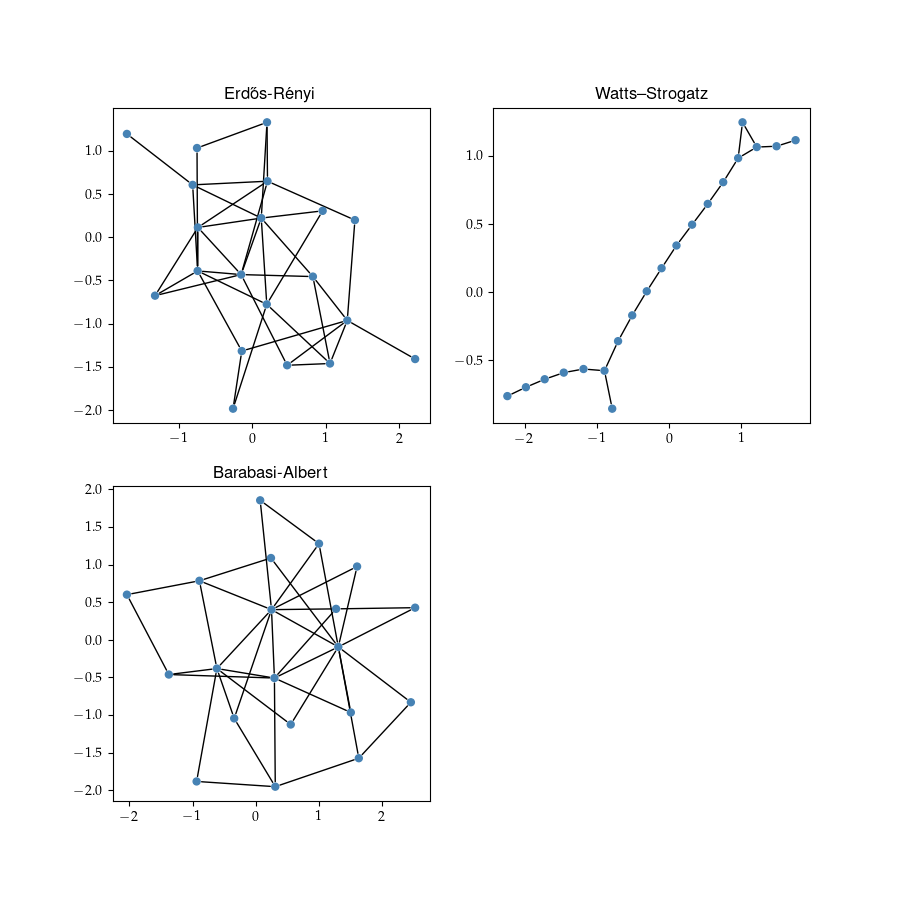

In [14]:
# Generate Erdos Renyi graphs based on probability
g_erdos_renyi = ig.Graph.Erdos_Renyi(n=N, p=0.2, directed=False, loops=False)
g_watts_strogatz = ig.Graph.Watts_Strogatz(dim = 1, size = 20, nei = 1, p = 0.2)
g_barabasi_albert = ig.Graph.Barabasi(n = N, m = 2 )

# Print out summaries of each graph
print("Erdos-Renyi: {} \n Watts-Strogatz: {} \n Barabasi-Albert: {}".format(
    str(g_erdos_renyi), str(g_barabasi_albert), str(g_watts_strogatz)))


#new figure to plot network graphs
fig_graph = plt.figure(figsize = (9, 9) )
axs_graph = [fig_graph.add_subplot(2,2,1), fig_graph.add_subplot(2,2,2), fig_graph.add_subplot(2,2,3)]
ig.plot(g_erdos_renyi, target=axs_graph[0], color='pink')
ig.plot(g_watts_strogatz, target=axs_graph[1])
ig.plot(g_barabasi_albert, target=axs_graph[2])
for i in range(len(axs_graph)):  
    axs_graph[i].set(title=name_graph[i+1])


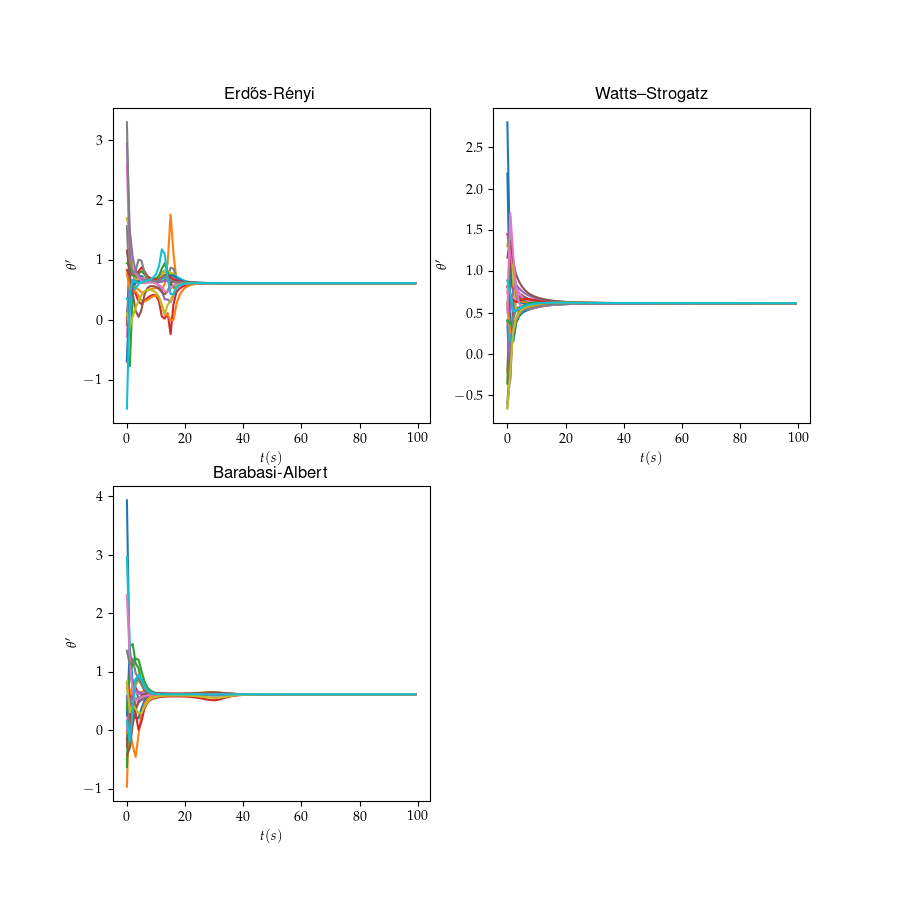

In [15]:
fig_plot = plt.figure(figsize = (9, 9) )
axs_plot = [fig_plot.add_subplot(2,2,1), fig_plot.add_subplot(2,2,2), fig_plot.add_subplot(2,2,3)]

q_plot_erd_ren, dq_plot_erd_ren = motion(q_0, omegas, t_max, dt, g_erdos_renyi)
axs_plot[0].clear()
axs_plot[0].plot(t_span[::10], dq_plot_erd_ren[::10, 0:20])

q_plot_watt_strog, dq_plot_watt_strog = motion(q_0, omegas, t_max, dt, g_watts_strogatz)
axs_plot[1].clear()
axs_plot[1].plot(t_span[::10], dq_plot_watt_strog[::10, 0:20])

q_plot_barabasi_albert, dq_plot_barabasi_albert = motion(q_0, omegas, t_max, dt, g_barabasi_albert)
axs_plot[2].clear()
axs_plot[2].plot(t_span[::10], dq_plot_barabasi_albert[::10, 0:20])

for i in range(len(axs_plot)):  
    axs_plot[i].set(xlabel="$t (s)$", ylabel=r"$\theta '$", title=name_graph[i+1])
